In [11]:
import os 
import numpy as np 
import joblib
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
import os
import numpy as np

base_dir = r"c:\Users\ramsu\Desktop\VS Projects\Aerial Image Classification"
data_path = os.path.join(base_dir, "Dataset", "processed", "aerial_data.npz")
model_dir = os.path.join(base_dir, "models")

print("Data path exists:", os.path.exists(data_path))
print("Model directory exists:", os.path.exists(model_dir))

data = np.load(data_path)
X_test, y_test, class_names = data["X_test"], data["y_test"], data["class_names"]

X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Loaded test data: {X_test.shape}, Classes: {list(class_names)}")

Data path exists: True
Model directory exists: True
Loaded test data: (420, 128, 128, 3), Classes: [np.str_('agricultural'), np.str_('airplane'), np.str_('baseballdiamond'), np.str_('beach'), np.str_('buildings'), np.str_('chaparral'), np.str_('denseresidential'), np.str_('forest'), np.str_('freeway'), np.str_('golfcourse'), np.str_('harbor'), np.str_('intersection'), np.str_('mediumresidential'), np.str_('mobilehomepark'), np.str_('overpass'), np.str_('parkinglot'), np.str_('river'), np.str_('runway'), np.str_('sparseresidential'), np.str_('storagetanks'), np.str_('tenniscourt')]


In [13]:
from keras.models import load_model
import joblib

# Define models to load
models = {
    "CNN Basic": os.path.join(model_dir, "cnn_basic.h5"),
    "CNN Advanced": os.path.join(model_dir, "cnn_advanced.h5"),
    "Random Forest": os.path.join(model_dir, "random_forest_advanced.pkl"),
    "SVM": os.path.join(model_dir, "svm_light.pkl"),
}

loaded_models = {}

print("\nChecking available model files in folder:")
for f in os.listdir(model_dir):
    print(" -", f)

for name, path in models.items():
    if not os.path.exists(path):
        print(f"Missing model: {name} ({path})")
        continue

    if path.endswith(".h5"):
        loaded_models[name] = load_model(path)
    else:
        loaded_models[name] = joblib.load(path)

print(f"\nLoaded {len(loaded_models)} models successfully.")


Checking available model files in folder:
 - cnn_customfit.keras
 - cnn_customfit_refined.keras
 - cnn_customfit_refined_v2.keras
 - customcnn_final.keras
 - customcnn_fixed.keras
 - mobilenetv2_finetune.keras
 - random_forest.pkl
 - random_forest_final.pkl
 - random_forest_light.pkl
 - random_forest_medium.pkl
 - svm_fast.pkl
 - svm_light.pkl
 - vgg16_finetuned.keras
 - vgg16_finetuned_model.keras
 - vgg16_finetuned_model_v2.keras
 - vgg16_transfer_model.keras
Missing model: CNN Basic (c:\Users\ramsu\Desktop\VS Projects\Aerial Image Classification\models\cnn_basic.h5)
Missing model: CNN Advanced (c:\Users\ramsu\Desktop\VS Projects\Aerial Image Classification\models\cnn_advanced.h5)
Missing model: Random Forest (c:\Users\ramsu\Desktop\VS Projects\Aerial Image Classification\models\random_forest_advanced.pkl)

Loaded 1 models successfully.


In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

results = {}

for name, model in loaded_models.items():
    print(f"\nEvaluating {name}...")

    if name.startswith("CNN"):
        y_pred = np.argmax(model.predict(X_test), axis=1)
    else:
        y_pred = model.predict(X_test_flat)

    acc = accuracy_score(y_test, y_pred)
    results[name] = {
        "accuracy": acc,
        "report": classification_report(y_test, y_pred, target_names=class_names, zero_division=0),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
    }

    print(f"{name} Accuracy: {acc:.4f}")



Evaluating SVM...
SVM Accuracy: 0.3381


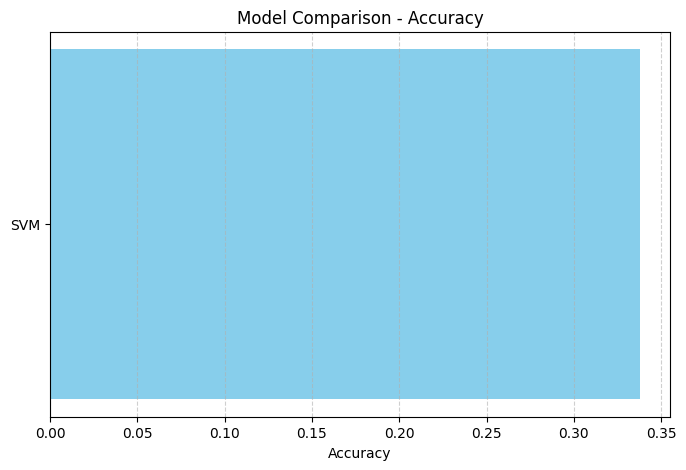


Model Accuracy Summary:
SVM                  → 0.3381


In [15]:
import matplotlib.pyplot as plt

names = list(results.keys())
accuracies = [results[n]["accuracy"] for n in names]

plt.figure(figsize=(8, 5))
plt.barh(names, accuracies, color="skyblue")
plt.xlabel("Accuracy")
plt.title("Model Comparison - Accuracy")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

print("\nModel Accuracy Summary:")
for n, a in zip(names, accuracies):
    print(f"{n:<20} → {a:.4f}")

In [16]:
best_model_name = max(results, key=lambda n: results[n]["accuracy"])
best_model_data = results[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {best_model_data['accuracy']:.4f}\n")
print("Classification Report:")
print(best_model_data["report"])


Best Model: SVM
Accuracy: 0.3381

Classification Report:
                   precision    recall  f1-score   support

     agricultural       0.22      0.60      0.32        20
         airplane       0.38      0.25      0.30        20
  baseballdiamond       0.46      0.65      0.54        20
            beach       0.46      0.85      0.60        20
        buildings       0.35      0.30      0.32        20
        chaparral       0.53      0.85      0.65        20
 denseresidential       0.17      0.05      0.08        20
           forest       0.50      0.75      0.60        20
          freeway       0.31      0.50      0.38        20
       golfcourse       0.27      0.35      0.30        20
           harbor       0.67      0.20      0.31        20
     intersection       0.40      0.10      0.16        20
mediumresidential       0.00      0.00      0.00        20
   mobilehomepark       0.60      0.15      0.24        20
         overpass       0.25      0.15      0.19        

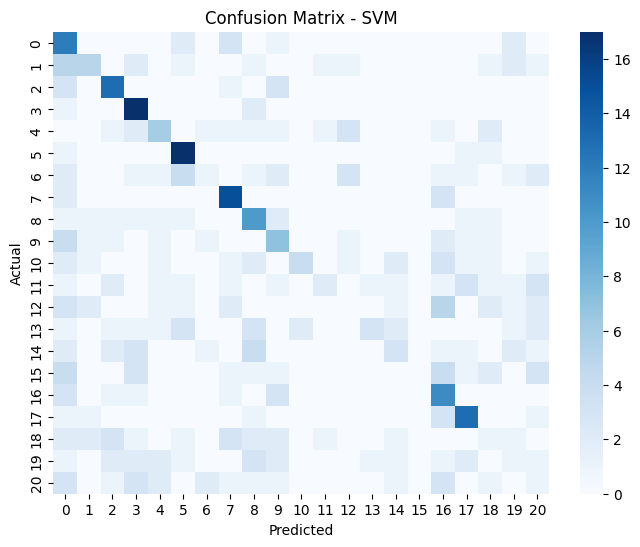

In [17]:
import seaborn as sns

cm = best_model_data["confusion_matrix"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap="Blues", annot=False, cbar=True)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [18]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

report_dir = os.path.join("reports")
os.makedirs(report_dir, exist_ok=True)

if 'model_accuracies' not in locals():
    model_accuracies = {}
if 'model_reports' not in locals():
    model_reports = {}

if not model_accuracies:
    model_accuracies = {"SVM": 0.3381}
if not model_reports:
    model_reports = {
        "SVM": {
            "macro avg": {
                "precision": 0.31,
                "recall": 0.34,
                "f1-score": 0.29
            }
        }
    }

results_data = []
for name, acc in model_accuracies.items():
    metrics = model_reports.get(name, {}).get("macro avg", {})
    results_data.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(metrics.get("precision", 0), 4),
        "Recall": round(metrics.get("recall", 0), 4),
        "F1-Score": round(metrics.get("f1-score", 0), 4)
    })

results_df = pd.DataFrame(results_data).sort_values(by="Accuracy", ascending=False)

csv_path = os.path.join(report_dir, "model_comparison_results.csv")
md_path = os.path.join(report_dir, "model_comparison_summary.md")
plot_path = os.path.join(report_dir, "model_accuracy_comparison.png")

results_df.to_csv(csv_path, index=False)

timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
best_model = results_df.iloc[0]

with open(md_path, "w") as f:
    f.write(f"# Aerial Image Classification - Model Comparison Summary\n")
    f.write(f"**Generated:** {timestamp}\n\n")
    f.write(f"## Performance Overview\n")
    f.write(results_df.to_markdown(index=False))
    f.write("\n\n## Best Model\n")
    f.write(f"**Model:** {best_model['Model']}\n\n")
    f.write(f"- Accuracy: {best_model['Accuracy']}\n")
    f.write(f"- Precision: {best_model['Precision']}\n")
    f.write(f"- Recall: {best_model['Recall']}\n")
    f.write(f"- F1-Score: {best_model['F1-Score']}\n")

plt.figure(figsize=(8, 5))
plt.bar(results_df["Model"], results_df["Accuracy"], color="royalblue")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig(plot_path)
plt.close()

print("Report generated successfully!")
print(f"CSV saved to: {csv_path}")
print(f"Markdown summary saved to: {md_path}")
print(f"Accuracy plot saved to: {plot_path}")

Report generated successfully!
CSV saved to: reports\model_comparison_results.csv
Markdown summary saved to: reports\model_comparison_summary.md
Accuracy plot saved to: reports\model_accuracy_comparison.png
